<a href="https://colab.research.google.com/github/robgon-art/open-clip/blob/main/Search_for_LOC_Photos_with_OpenCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Search for Library of Congress Photos with OpenCLIP

This is a self-contained notebook that shows how to download and run Open CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

In [1]:
!nvidia-smi

Sun Mar  5 19:19:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install open_clip_torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 13.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which

In [3]:
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [4]:
!gdown 1-5-cP2rVztAGNk_rxUXa_g9psIZYjUHR

Downloading...
From: https://drive.google.com/uc?id=1-5-cP2rVztAGNk_rxUXa_g9psIZYjUHR
To: /content/image_features_and_urls.npz
100% 94.6M/94.6M [00:01<00:00, 58.2MB/s]


In [5]:
!mkdir photos

In [6]:
import numpy as np
import torch
data = np.load("image_features_and_urls.npz")
image_features_np = data["features"]
global_urls = data["urls"]

In [7]:
print(global_urls[:3])
print(len(global_urls))

['https://live.staticflickr.com/1091/3174186405_4654a14ae4.jpg'
 'https://live.staticflickr.com/1566/25073678794_25b3a07760.jpg'
 'https://live.staticflickr.com/7452/12678837593_4ffcac770d.jpg']
41216


In [8]:
import open_clip
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_e16')
model.cuda().eval()

100%|███████████████████████████████████████| 605M/605M [00:07<00:00, 78.4MiB/s]


CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0): ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
        (1): ResidualAttentionBlock(
          (l

In [9]:
def get_items_with_scores(scores, items, n=8):
  sorted_items = sorted(zip(scores, items), reverse=True)
  top_items_with_scores = [(item, score) for score, item in sorted_items[:n]]
  return top_items_with_scores

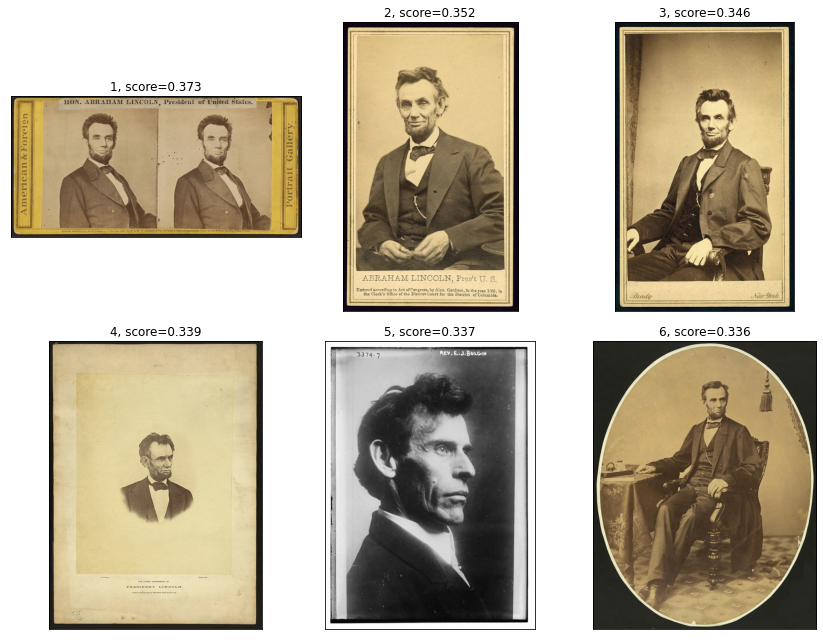

In [10]:
from open_clip import tokenizer
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import os

two_rows = True
search_phrase = "Abraham Lincoln" #@param {type:"string"}

text_tokens = tokenizer.tokenize(search_phrase).cuda()
with torch.no_grad():
  text_features = model.encode_text(text_tokens).float()
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features_np.T

path_names = []
scores = []
folder = "/content/photos"

top_items_with_scores = get_items_with_scores(list(similarity.squeeze()), 
                                              global_urls, 6)
for url, score in top_items_with_scores:
  file_name = url.split("/")[-1]
  path_name = os.path.join(folder, file_name)
  urllib.request.urlretrieve(url, path_name)
  path_names.append(path_name)
  scores.append(score)

if two_rows:
  plt.figure(figsize=(12, 9))
else:
  plt.figure(figsize=(18, 6))

i=0
for p, s in zip(path_names, scores):
  image = Image.open(p).convert("RGB")
  if two_rows:
    plt.subplot(2, 3, i + 1)
  else:
    plt.subplot(1, 6, i + 1)
  plt.imshow(image)
  plt.title(str(i+1) + ", score=" + str(round(s, 3)))
  plt.xticks([])
  plt.yticks([])
  i += 1

plt.tight_layout()

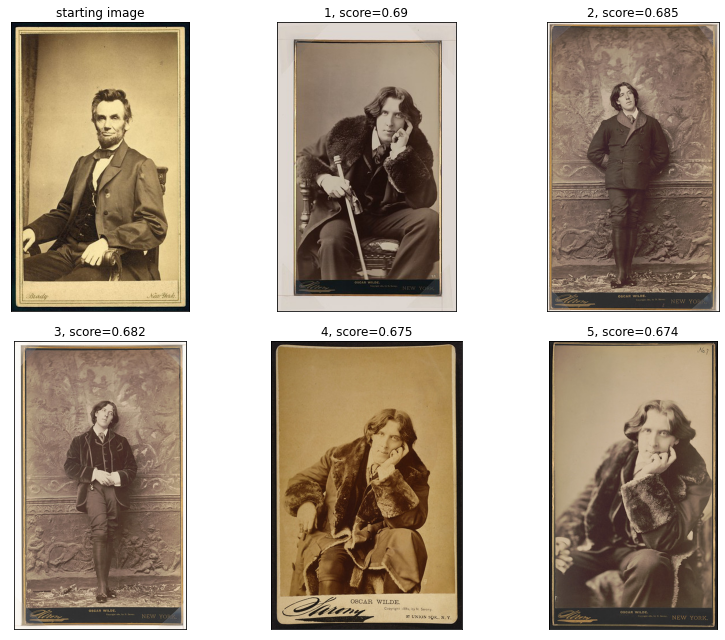

In [11]:
starting_image = 3 #@param {type:"slider", min:1, max:6, step:1}
positive_prompt = "Oscar Wilde" #@param {type:"string"}
negative_prompt = "Abraham Lincoln" #@param {type:"string"}
scaling_factor = 1 #@param {type:"slider", min:0.0, max:5.0, step:0.1}

starting_file = path_names[starting_image-1]
image = Image.open(starting_file).convert("RGB")
processed_image = preprocess(image)
processed_image = processed_image[None, :].cuda()

with torch.no_grad():
  starting_features = model.encode_image(processed_image).float()
starting_features /= starting_features.norm(dim=-1, keepdim=True)

positive_tokens = tokenizer.tokenize(positive_prompt).cuda()
negative_tokens = tokenizer.tokenize(negative_prompt).cuda()

with torch.no_grad():
  positive_features = model.encode_text(positive_tokens).float()
  negative_features = model.encode_text(negative_tokens).float()

positive_features /= positive_features.norm(dim=-1, keepdim=True)
negative_features /= negative_features.norm(dim=-1, keepdim=True)

modified_features = starting_features + scaling_factor * (
                    positive_features - negative_features)

modified_features /= modified_features.norm(dim=-1, keepdim=True)

similarity = modified_features.cpu().numpy() @ image_features_np.T

modified_path_names = []
modified_scores = []
folder = "/content/photos"

top_items_with_scores = get_items_with_scores(list(similarity.squeeze()), 
                                              global_urls, 6)
for url, score in top_items_with_scores:
  # print(url, score)
  file_name = url.split("/")[-1]
  path_name = os.path.join(folder, file_name)
  urllib.request.urlretrieve(url, path_name)
  modified_path_names.append(path_name)
  modified_scores.append(score)

if two_rows:
  plt.figure(figsize=(12, 9))
else:
  plt.figure(figsize=(18, 6))

modified_path_names.insert(0, starting_file)
modified_scores.insert(0, 1.0)

i=0
for p, s in zip(modified_path_names, modified_scores):
  if i>0 and p == starting_file:
    continue
  image = Image.open(p).convert("RGB")
  if two_rows:
    plt.subplot(2, 3, i + 1)
  else:
    plt.subplot(1, 6, i + 1)
  plt.imshow(image)
  if i==0:
    plt.title("starting image")
  else:
    plt.title(str(i) + ", score=" + str(round(s, 3)))
  plt.xticks([])
  plt.yticks([])
  i += 1
  if i>= 6:
    break

plt.tight_layout()